In [18]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import deepxde as dde

In [21]:
S0 = 50000
F0 = 1
I0 = 0
beta = 2.0e-5
alpha = 0.05
p = 0.3

In [22]:
def sfi_model(y, x, beta, alpha,p):
    S = -y[0]* y[1] * beta
    F = y[0]* y[1] * beta * p  - y[1]* alpha
    I = (1-p) * beta * y[0]* y[1] + alpha * y[1]
    return S, F, I
def fit_odeint(x, beta, alpha , p):
    return integrate.odeint(sfi_model, (S0, F0, I0), x, args=(beta, alpha,p))[:,0],integrate.odeint(sfi_model, (S0, F0, I0), x, args=(beta, alpha,p))[:,1],integrate.odeint(sfi_model, (S0, F0, I0), x, args=(beta, alpha,p))[:,2]

In [25]:
x_data= np.arange(0,200)
s,f , i = fit_odeint(x_data,beta,alpha,p)

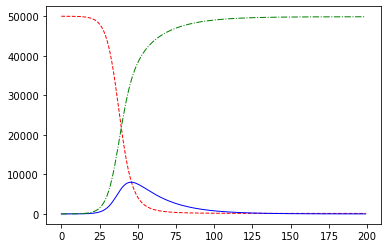

In [26]:
#画图
plt.plot(x_data, s, color="red", linewidth=1.0, linestyle="--")
plt.plot(x_data, f, color="blue", linewidth=1.0, linestyle="-")
plt.plot(x_data, i, color="green", linewidth=1.0, linestyle="-.")

In [27]:
ob_x = x_data.reshape((len(x_data),1))

In [28]:
ob_s = s.reshape((len(s),1))

In [29]:
ob_f = f.reshape((len(f),1))

In [30]:
ob_i = i.reshape((len(i),1))

In [31]:
ob_my_y = np.concatenate((ob_s,ob_f,ob_i),axis = 1)

In [32]:
C1 = dde.Variable(0.5)  #beta
C2 = dde.Variable(0.5)  #p
C3 = dde.Variable(2.0)  #alpha

In [33]:
def sfi_model_deepxde(x,y):
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x + C1 * y2 * y1,
        dy2_x - C1 * C2 * y1 * y2 + C3 * y2,
        dy3_x - C3 * y2 + C1 * (1-C2) * y1 * y2,
    ]
def boundary(_, on_initial):
    return on_initial

In [34]:
geom = dde.geometry.TimeDomain(0, 59)

In [35]:
# Initial conditions
ic1 = dde.icbc.IC(geom, lambda X: 50000, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 1, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 0, boundary, component=2)

In [36]:
observe_y0 = dde.icbc.PointSetBC(ob_x, ob_my_y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(ob_x, ob_my_y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(ob_x, ob_my_y[:, 2:3], component=2)

In [37]:
data = dde.data.PDE(
    geom,
    sfi_model_deepxde,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=1000,      #数值采样个数和边缘概率
    num_boundary=20,
    anchors=ob_x,
)

In [ ]:
net = dde.nn.FNN([1] + [30] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[C1, C2, C3])
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], period=600, filename="variables.dat"
)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000145 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.59e-02, 3.20e+00, 3.18e+00, 2.50e+09, 1.00e+00, 0.00e+00, 4.32e+08, 7.51e+06, 1.82e+09]    [2.59e-02, 3.20e+00, 3.18e+00, 2.50e+09, 1.00e+00, 0.00e+00, 4.32e+08, 7.51e+06, 1.82e+09]    []  
1000      [3.83e+01, 4.64e+01, 4.67e+01, 2.50e+09, 2.75e+02, 4.64e+02, 4.31e+08, 7.42e+06, 1.82e+09]    [3.83e+01, 4.64e+01, 4.67e+01, 2.50e+09, 2.75e+02, 4.64e+02, 4.31e+08, 7.42e+06, 1.82e+09]    []  
2000      [3.42e+00, 2.69e+00, 3.15e+00, 2.49e+09, 1.11e+03, 1.48e+03, 4.31e+08, 7.33e+06, 1.82e+09]    [3.42e+00, 2.69e+00, 3.15e+00, 2.49e+09, 1.11e+03, 1.48e+03, 4.31e+08, 7.33e+06, 1.82e+09]    []  
3000      [1.07e+01, 9.09e+00, 1.01e+01, 2.49e+09, 2.47e+03, 3.08e+03, 4.30e+08, 7.25e+06, 1.82e+09]    [1.07e+01, 9

40000     [5.01e+03, 4.32e+03, 2.65e+03, 2.38e+09, 2.71e+05, 4.68e+05, 4.09e+08, 5.47e+06, 1.73e+09]    [5.01e+03, 4.32e+03, 2.65e+03, 2.38e+09, 2.71e+05, 4.68e+05, 4.09e+08, 5.47e+06, 1.73e+09]    []  
41000     [2.56e+03, 2.53e+03, 2.60e+03, 2.37e+09, 2.66e+05, 4.91e+05, 4.08e+08, 5.46e+06, 1.73e+09]    [2.56e+03, 2.53e+03, 2.60e+03, 2.37e+09, 2.66e+05, 4.91e+05, 4.08e+08, 5.46e+06, 1.73e+09]    []  
42000     [9.31e+03, 4.99e+03, 3.63e+03, 2.37e+09, 2.60e+05, 5.15e+05, 4.08e+08, 5.45e+06, 1.72e+09]    [9.31e+03, 4.99e+03, 3.63e+03, 2.37e+09, 2.60e+05, 5.15e+05, 4.08e+08, 5.45e+06, 1.72e+09]    []  
43000     [4.25e+03, 4.02e+03, 2.83e+03, 2.37e+09, 2.55e+05, 5.40e+05, 4.07e+08, 5.45e+06, 1.72e+09]    [4.25e+03, 4.02e+03, 2.83e+03, 2.37e+09, 2.55e+05, 5.40e+05, 4.07e+08, 5.45e+06, 1.72e+09]    []  
44000     [2.90e+03, 2.88e+03, 2.95e+03, 2.36e+09, 2.49e+05, 5.65e+05, 4.07e+08, 5.44e+06, 1.72e+09]    [2.90e+03, 2.88e+03, 2.95e+03, 2.36e+09, 2.49e+05, 5.65e+05, 4.07e+08, 5.44e+06, 1.7